# Deep Learning & Art: Neural Style Transfer

This algorithm was created by Gatys et al. (2015) (https://arxiv.org/abs/1508.06576). 

In [1]:
import os
import sys
import scipy.io
import scipy.misc
print(sys.executable)
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import cv2

%matplotlib inline

/home/devendra/anaconda3/envs/tf/bin/python


## 1 - Problem Statement

In this example, you are going to generate an image of the Louvre museum in Paris (content image C), mixed with a painting by Claude Monet, a leader of the impressionist movement (style image S).
<img src="images/louvre_generated.png" style="width:750px;height:200px;">

Let's see how you can do this. 

## 2 - Transfer Learning

Pre trained VGG-19 Model will be used

In [2]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

The model is stored in a python dictionary where each variable name is the key and the corresponding value is a tensor containing that variable's value. To run an image through this network, you just have to feed the image to the model. In TensorFlow, you can do so using the [tf.assign](https://www.tensorflow.org/api_docs/python/tf/assign) function. In particular, you will use the assign function like this:  
```python
model["input"].assign(image)
```
This assigns the image as an input to the model. After this, if you want to access the activations of a particular layer, say layer `4_2` when the network is run on this image, you would run a TensorFlow session on the correct tensor `conv4_2`, as follows:  
```python
sess.run(model["conv4_2"])
```

## 3 - Neural Style Transfer 

We will build the NST algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 3.1 Computing the content cost

/home/devendra/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


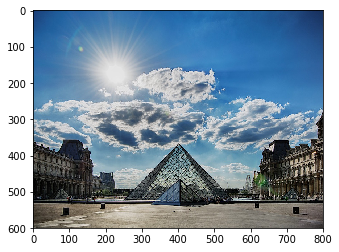

In [3]:
content_image = scipy.misc.imread('images/louvre.jpg')
imshow(content_image)

#### Formula to calculate content cost

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

<img src="images/NST_LOSS.png" style="width:800px;height:400px;">

1. Retrieve dimensions from a_G: 
    - To retrieve dimensions from a tensor X, use: `X.get_shape().as_list()`
2. Unroll a_C and a_G as explained in the picture above
    - If you are stuck, take a look at [Hint1](https://www.tensorflow.org/versions/r1.3/api_docs/python/tf/transpose) and [Hint2](https://www.tensorflow.org/versions/r1.2/api_docs/python/tf/reshape).
3. Compute the content cost:
    - If you are stuck, take a look at [Hint3](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [Hint4](https://www.tensorflow.org/api_docs/python/tf/square) and [Hint5](https://www.tensorflow.org/api_docs/python/tf/subtract).

In [4]:
def compute_content_cost(a_C , a_G):
    """
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    m , n_H , n_W , n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.transpose(tf.reshape(a_C,[n_H*n_W,n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G,[n_H*n_W,n_C]))
    
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))/(4*n_H*n_W*n_C)
    return J_content

In [5]:
tf.reset_default_graph()

with tf.Session() as sess:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1,4,4,3],mean=1,stddev=4)
    a_G = tf.random_normal([1,4,4,3],mean=1,stddev=4)
    
    J_content = compute_content_cost(a_C,a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.7655926


### 3.2 - Computing the style cost

/home/devendra/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


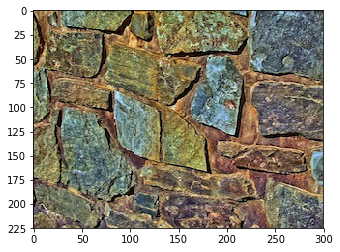

In [6]:
style_image = scipy.misc.imread('images/stone_style.jpg')
imshow(style_image)

### 3.2.1 - Style Matrix

The style matrix is also called a "Gram matrix." In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

Note that there is an unfortunate collision in the variable names used here. We are following common terminology used in the literature, but $G$ is used to denote the Style matrix (or Gram matrix) as well as to denote the generated image $G$. We will try to make sure which $G$ we are referring to is always clear from the context. 

In NST, you can compute the Style matrix by multiplying the "unrolled" filter matrix with their transpose:

<img src="images/NST_GM.png" style="width:900px;height:300px;">

Using TensorFlow, implement a function that computes the Gram matrix of a matrix A. The formula is: The gram matrix of A is $G_A = AA^T$. If you are stuck, take a look at [Hint 1](https://www.tensorflow.org/api_docs/python/tf/matmul) and [Hint 2](https://www.tensorflow.org/api_docs/python/tf/transpose).

In [7]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = tf.matmul(A,tf.transpose(A))
    
    return GA

In [8]:
tf.reset_default_graph()

with tf.Session() as sess:
    tf.set_random_seed(1)
    A = tf.random_normal([3,2*1],mean=1,stddev=4)
    GA = gram_matrix(A)
    print("gram matrix = " + str(GA.eval()))

gram matrix = [[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


### 3.2.2 - Style Cost

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

1. Retrieve dimensions from the hidden layer activations a_G: 
    - To retrieve dimensions from a tensor X, use: `X.get_shape().as_list()`
2. Unroll the hidden layer activations a_S and a_G into 2D matrices, as explained in the picture above.
    - You may find [Hint1](https://www.tensorflow.org/versions/r1.3/api_docs/python/tf/transpose) and [Hint2](https://www.tensorflow.org/versions/r1.2/api_docs/python/tf/reshape) useful.
3. Compute the Style matrix of the images S and G. (Use the function you had previously written.) 
4. Compute the Style cost:
    - You may find [Hint3](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [Hint4](https://www.tensorflow.org/api_docs/python/tf/square) and [Hint5](https://www.tensorflow.org/api_docs/python/tf/subtract) useful.

In [9]:
def compute_layer_style_cost(a_S,a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G

    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    #step 1
    m , n_H , n_W , n_C = a_G.get_shape().as_list()
    
    #step 2
    a_S = tf.transpose(tf.reshape(a_S,[n_H*n_W,n_C]))
    a_G = tf.transpose(tf.reshape(a_G,[n_H*n_W,n_C]))
    
    #step 3
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    #step 4
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GG,GS)))/(4*n_C**2*(n_W*n_H)**2)
    
    return J_style_layer

In [10]:
tf.reset_default_graph()

with tf.Session() as sess:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1,4,4,3],mean=1,stddev=4)
    a_G = tf.random_normal([1,4,4,3],mean=1,stddev=4)
    J_style_layer = compute_layer_style_cost(a_S,a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190275


### 3.2.3 Style weights

So far you have captured the style from only one layer. We'll get better results if we "merge" style costs from several different layers.

In [11]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


In [12]:
def compute_style_cost(model,STYLE_LAYERS):
    J_style = 0
    
    for layer_name,coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        
        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S,a_G)
        
        J_style += coeff*J_style_layer
        
    return J_style

### 3.3 - Defining the total cost to optimize

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$


In [13]:
def total_cost(J_content , J_style , alpha=10,beta=40):
    J = alpha*J_content + beta*J_style
    return J

In [14]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(3)
    J_content = np.random.randn()
    J_style = np.random.randn()
    J = total_cost(J_content , J_style)
    print("J = " + str(J))

J = 35.34667875478276


## 4 - Solving the optimization problem

Finally, let's put everything together to implement Neural Style Transfer!


Here's what the program will have to do:
<font color='purple'>

1. Create an Interactive Session
2. Load the content image 
3. Load the style image
4. Randomly initialize the image to be generated 
5. Load the VGG16 model
7. Build the TensorFlow graph:
    - Run the content image through the VGG16 model and compute the content cost
    - Run the style image through the VGG16 model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate
8. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step.

</font>

In [15]:
#Reset the graph
tf.reset_default_graph()

#start interactive session
sess = tf.InteractiveSession()

In [16]:
#load the content image
content_image = cv2.imread('images/louvre.jpg')
#imshow(content_image)
#print(type(content_image))
print(content_image.shape)
#content_image = reshape_and_normalize_image(content_image)
print(content_image.shape)

(600, 800, 3)
(600, 800, 3)


In [17]:
style_image = cv2.imread('images/stone_style.jpg')
print(type(style_image))
#imshow(style_image)
print(style_image.shape)
#style_image = reshape_and_normalize_image(style_image)
print(style_image.shape)

<class 'numpy.ndarray'>
(225, 300, 3)
(225, 300, 3)


In [18]:
noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS))
print(noise_image.shape)
content_image = cv2.resize(content_image,(CONFIG.IMAGE_WIDTH, CONFIG.IMAGE_HEIGHT))
style_image = cv2.resize(style_image,(CONFIG.IMAGE_WIDTH, CONFIG.IMAGE_HEIGHT))
print(content_image.shape)
content_image = reshape_and_normalize_image(content_image)
style_image = reshape_and_normalize_image(style_image)
print(content_image.shape)

(1, 300, 400, 3)
(300, 400, 3)
(1, 300, 400, 3)


In [19]:
generated_image = noise_image * CONFIG.NOISE_RATIO + content_image * (1 - CONFIG.NOISE_RATIO)
#generated_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


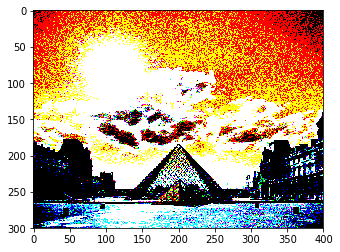

In [20]:
imshow(generated_image[0])

In [21]:
#Load the VGG16 model
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

To get the program to compute the content cost, we will now assign `a_C` and `a_G` to be the appropriate hidden layer activations. We will use layer `conv4_2` to compute the content cost. The code below does the following:

1. Assign the content image to be the input to the VGG model.
2. Set a_C to be the tensor giving the hidden layer activation for layer "conv4_2".
3. Set a_G to be the tensor giving the hidden layer activation for the same layer. 
4. Compute the content cost using a_C and a_G.

In [22]:
#assign content image to be the input to the VGG model
Input = model['input'].assign(content_image)
sess.run(Input)

#Set a_C to be the tensor giving the hidden layer activation for layer "conv4_2".
out = model['conv4_2']
a_C = sess.run(out)

#Set a_G to be the tensor giving the hidden layer activation for the same layer.
#isn't evaluated yet. Later in the code, we'll assign the image G as the model input
a_G = model['conv4_2']

#compute content cost using a_C and a_G
J_content = compute_content_cost(a_C,a_G)

At this point, a_G is a tensor and hasn't been evaluated. It will be evaluated and updated at each iteration when we run the Tensorflow graph in model_nn() below.

In [23]:
#assign style image to the input
Input = model['input'].assign(style_image)
sess.run(Input)

#compute the style cost
J_style = compute_style_cost(model,STYLE_LAYERS)

In [24]:
#calculating total cost
J = total_cost(J_content , J_style , alpha=20 , beta=40)

In [25]:
#define train step
train_step = tf.train.AdamOptimizer(2.0).minimize(J)

In [26]:
def model_nn(sess,input_image, num_iterations = 200):
    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
        sess.run(train_step)
        generated_image = sess.run(model['input'])
        
        if i%20==0:
            Jt,Jc,Js = sess.run([J,J_content,J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            save_image("output/"+str(i)+".png",generated_image)
    save_image("output/generated_image.jpg",generated_image)
    
    return generated_image

Iteration 0 :
total cost = 3535989200.0
content cost = 6910.4346
style cost = 88396270.0
Iteration 20 :
total cost = 371738900.0
content cost = 13940.765
style cost = 9286502.0
Iteration 40 :
total cost = 100791800.0
content cost = 14550.0625
style cost = 2512520.0
Iteration 60 :
total cost = 52572260.0
content cost = 14706.913
style cost = 1306953.0
Iteration 80 :
total cost = 34907224.0
content cost = 14852.535
style cost = 865254.3
Iteration 100 :
total cost = 25823858.0
content cost = 14968.504
style cost = 638112.2
Iteration 120 :
total cost = 20217966.0
content cost = 15081.341
style cost = 497908.5
Iteration 140 :
total cost = 16418234.0
content cost = 15184.816
style cost = 402863.44
Iteration 160 :
total cost = 13694030.0
content cost = 15281.805
style cost = 334709.84
Iteration 180 :
total cost = 11667656.0
content cost = 15370.065
style cost = 284006.38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


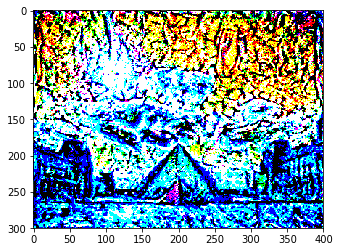

In [27]:
generated_image = model_nn(sess,generated_image)
imshow(generated_image[0])

### References:

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups from which we drew inspiration. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, Convolutional neural networks for artistic style transfer. https://harishnarayanan.org/writing/artistic-style-transfer/
- Log0, TensorFlow Implementation of "A Neural Algorithm of Artistic Style". http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style
- Karen Simonyan and Andrew Zisserman (2015). Very deep convolutional networks for large-scale image recognition (https://arxiv.org/pdf/1409.1556.pdf)
- MatConvNet. http://www.vlfeat.org/matconvnet/pretrained/
